In [ ]:
!pip install ydata-profiling

In [ ]:
#!pip install mlflow

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Example').getOrCreate()

24/06/08 00:58:34 WARN Utils: Your hostname, Ugurs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.30 instead (on interface en0)
24/06/08 00:58:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/08 00:58:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import sparkmon

# Create an app connection
# via a Spark session
application = sparkmon.create_application_from_spark(spark)
# or via a remote Spark web UI link
application = sparkmon.create_application_from_link(index=0, web_url='http://localhost:4040')

# Create and start the monitoring process
mon = sparkmon.SparkMon(application, period=5, callbacks=[
    sparkmon.callbacks.plot_to_image,
    sparkmon.callbacks.log_to_mlflow,
])
mon.start()

# Stop monitoring
#mon.stop()

In [3]:
spark

In [4]:
from utils import *

In [5]:
get_spark_app_id(spark)

'local-1717797515697'

                                             SPILL TEST

In [7]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

spark.sparkContext.setJobDescription('spill')  # Setting Job description
data = range(0, 1000000)
# Create DataFrame with a lot of records
df = spark.createDataFrame(data, "int").toDF("id")
df.cache().count()

# Create a temporary view so we can run SQL queries
df.createOrReplaceTempView("records")

# Force a spill. The high number of partitions and usage of `UNION ALL`
# will generate a big number of records in memory
df2 = spark.sql("""
    SELECT /*+ REPARTITION(1000) */ id 
    FROM records 
    UNION ALL 
    SELECT /*+ REPARTITION(1000) */ id 
    FROM records
""")
df2.cache().count()

2000000

In [9]:
# Simple usage:
mon = sparkmon.SparkMon(spark, period=5)
mon.start()

app = mon.application

In [7]:
mon.stop()

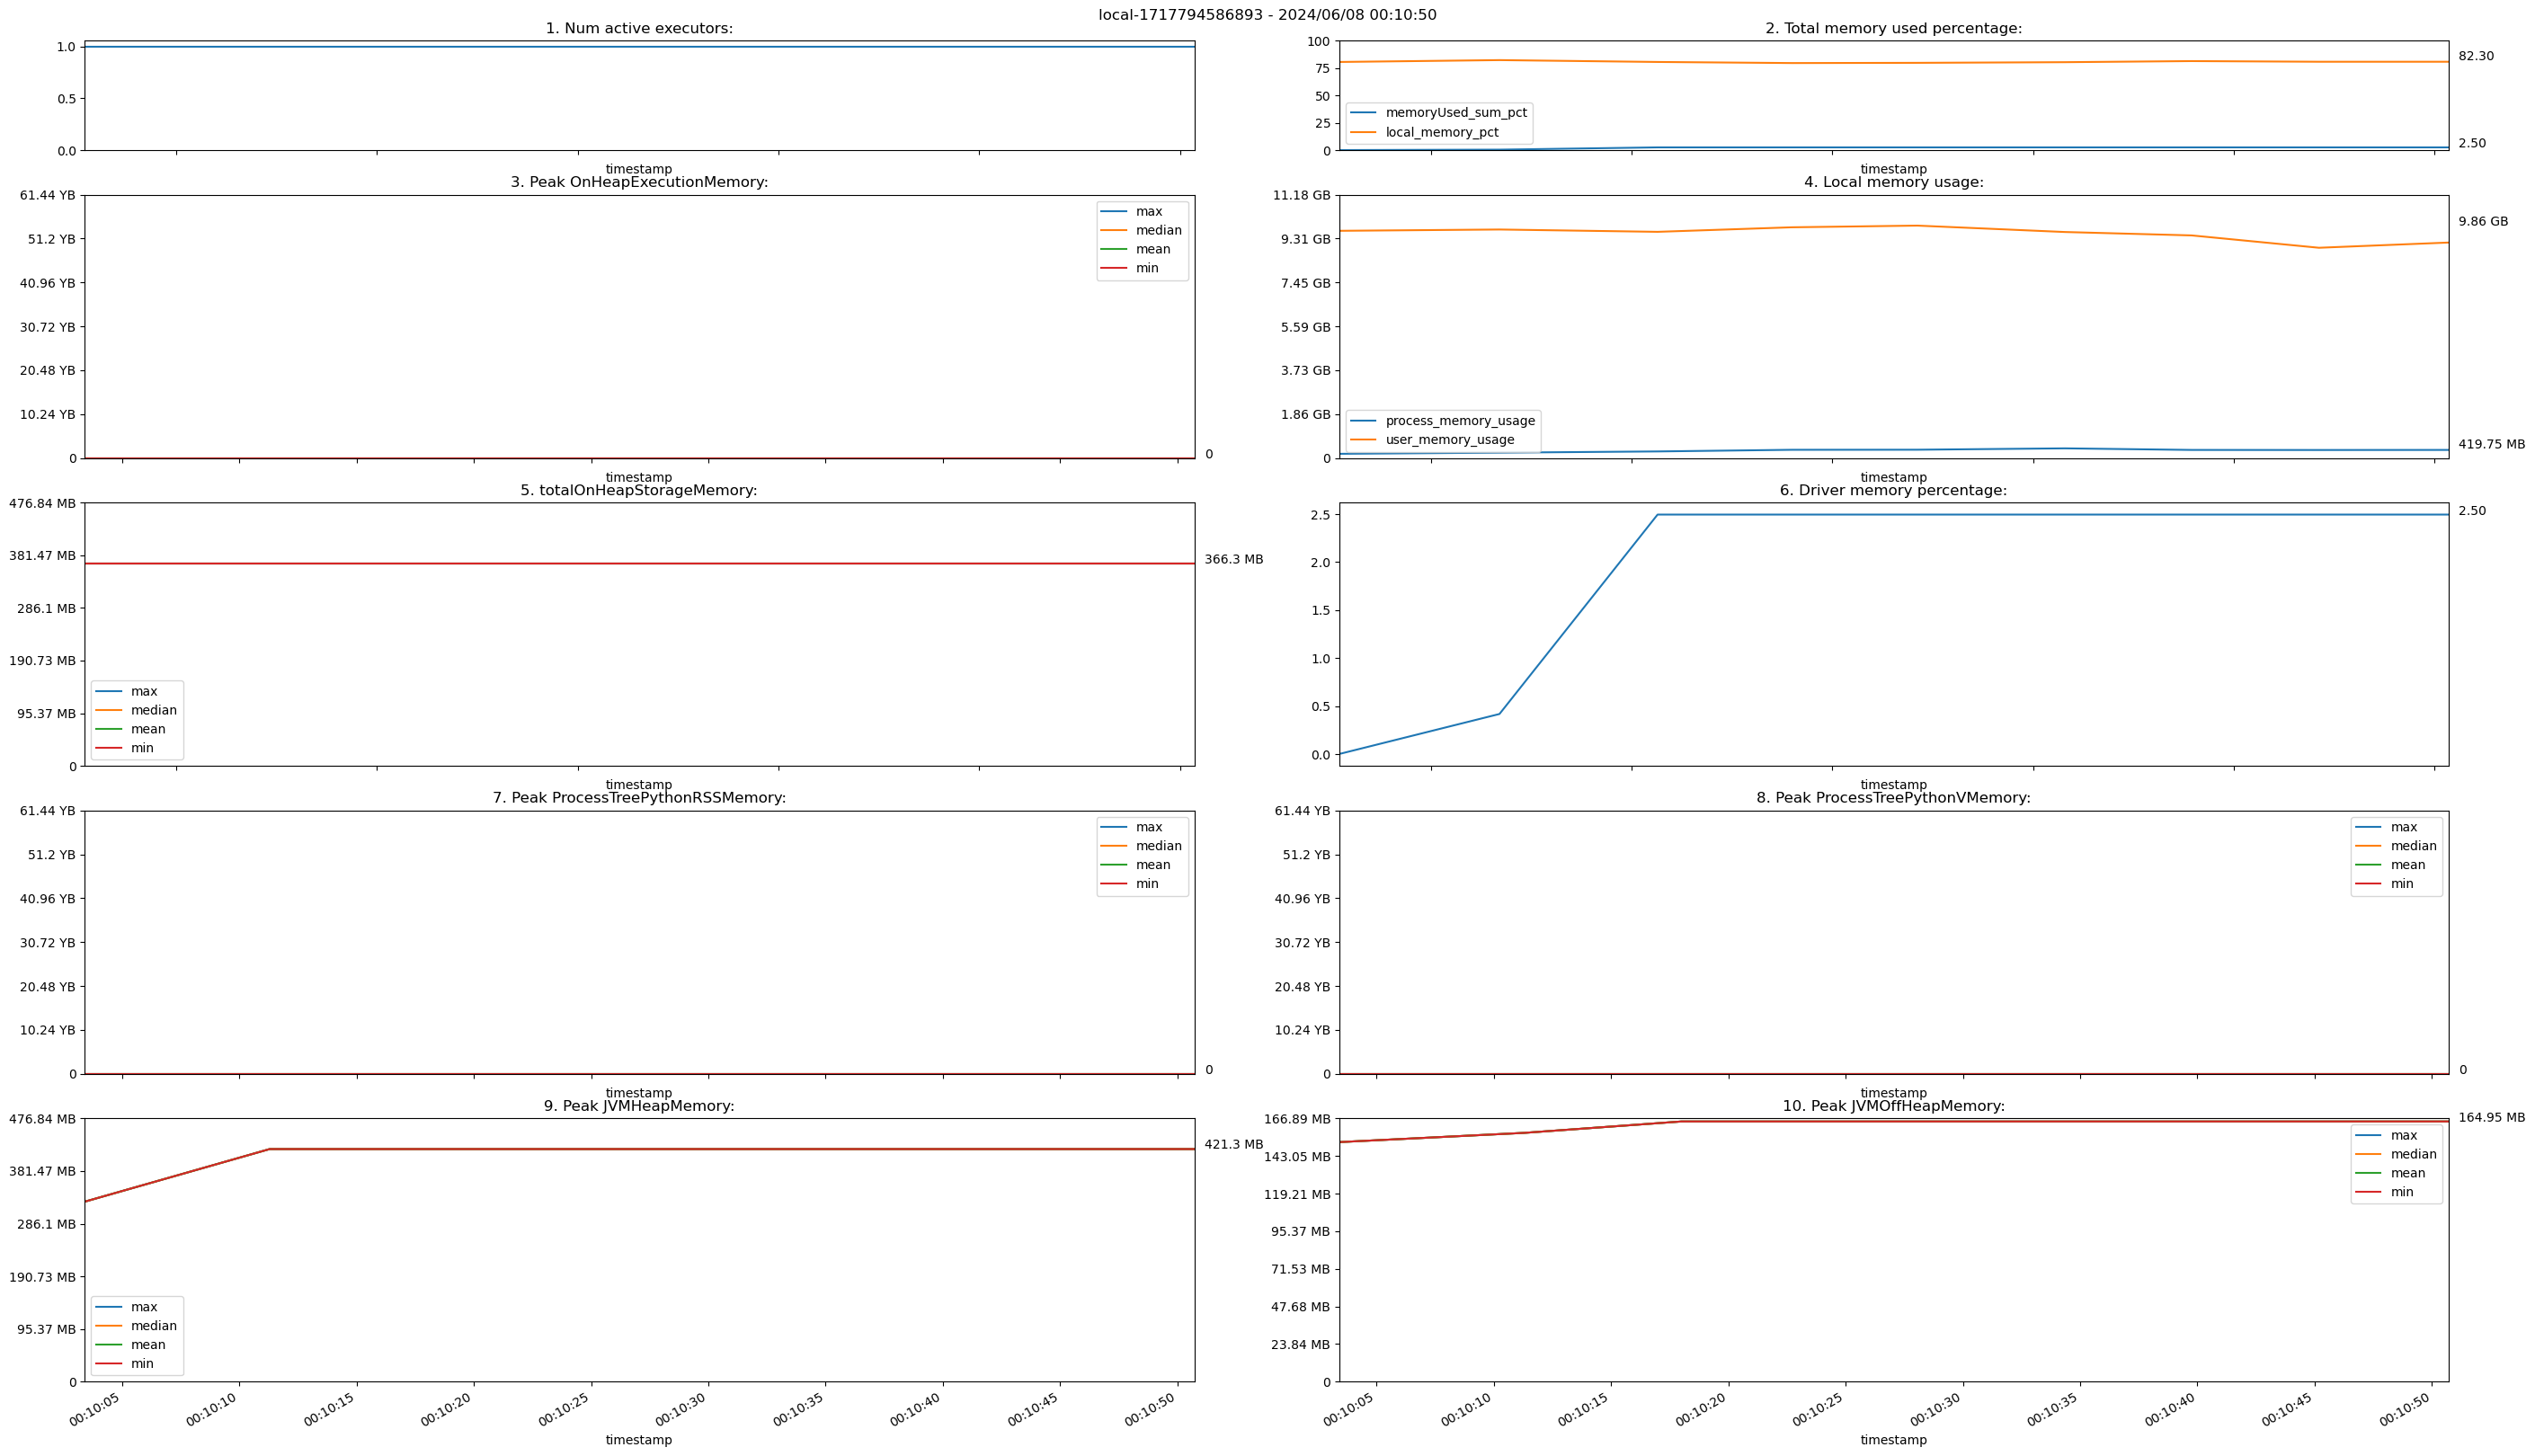

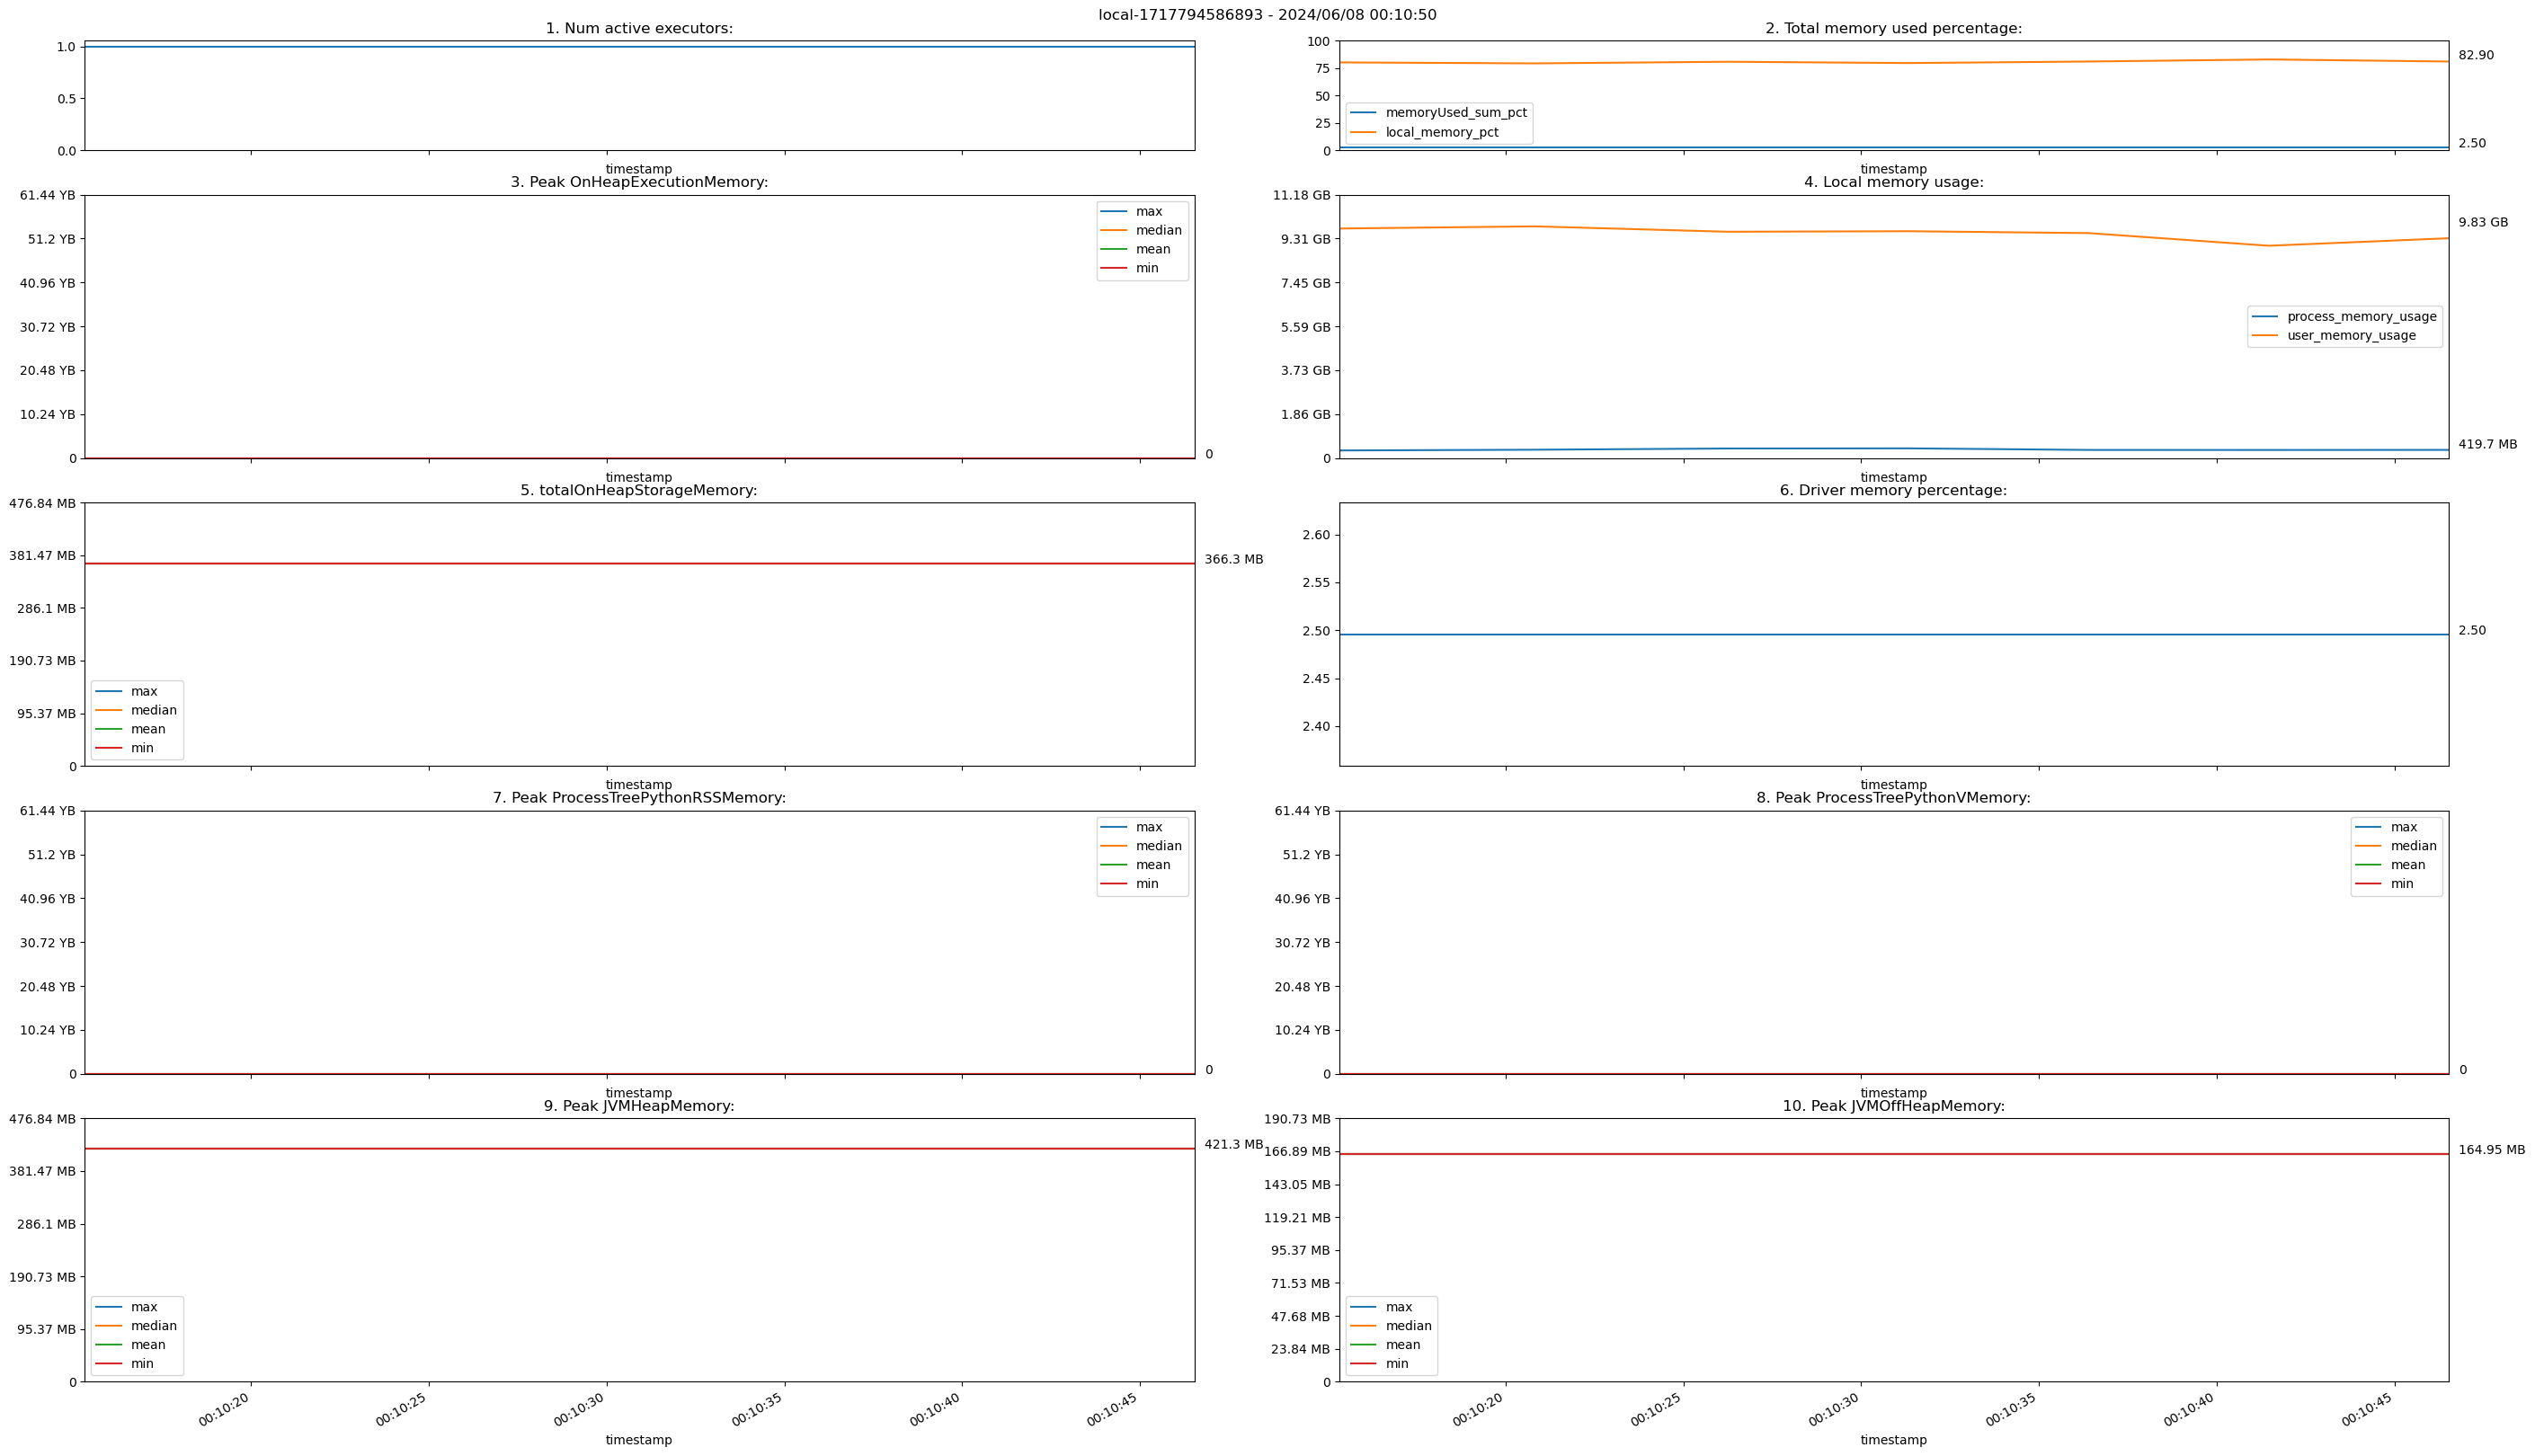

In [24]:
%matplotlib inline 
# This cannot be used with callbacks at the moment
mon.live_plot_notebook(n_iter=1)

In [26]:
# Re trigger parsing for development purposes
app.debug = True
app.parse_db()

In [13]:
weather = spark.read.parquet("/Users/ugurkalkavan/Downloads/m06sparkbasics/weather")
weather = weather.filter(weather["year"]==2022)
weather = weather.filter(weather["month"]==10)
weather = weather.filter(weather["day"]==23)

In [14]:
weather_pdf = weather.toPandas()

In [15]:
from ydata_profiling import ProfileReport
report = ProfileReport(weather_pdf, title="Profiling pyspark DataFrame")

In [ ]:
report

In [ ]:
#!git clone https://github.com/rokroskar/spark-pyrest.git

!python spark-pyrest/setup.py install

In [62]:
from sparkpyrest.spark_pyrest import SparkPyRest

spr = SparkPyRest("localhost")

In [64]:
spr.app

'local-1717797515697'

In [66]:
spr.stages

[(1731,
  'toPandas at /opt/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/spark/duplicates_spark.py:53'),
 (1730,
  'toPandas at /opt/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/spark/duplicates_spark.py:53'),
 (1729,
  'toPandas at /opt/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/spark/duplicates_spark.py:53'),
 (1728, 'count at <unknown>:0'),
 (1727, 'count at <unknown>:0'),
 (1726, 'count at <unknown>:0'),
 (1725, 'count at <unknown>:0'),
 (1724, 'count at <unknown>:0'),
 (1723, 'count at <unknown>:0'),
 (1722, 'count at <unknown>:0'),
 (1721, 'count at <unknown>:0'),
 (1720, 'count at <unknown>:0'),
 (1719, 'count at <unknown>:0'),
 (1718, 'count at <unknown>:0'),
 (1717, 'count at <unknown>:0'),
 (1716,
  'toPandas at /opt/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/spark/sample_spark.py:28'),
 (1715,
  'head at /opt/anaconda3/lib/python3.11/site-packages/ydata_profiling/model/spark/sample_spark.py:22'),
 (1714, 'co

                                                    SKEW TEST

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col
import random

# Spark session oluşturuluyor
spark.sparkContext.setJobDescription('skew')  # Setting Job description
sc = spark.sparkContext

# Büyük bir RDD yaratılıyor
rdd = sc.parallelize([(i, random.randint(0,1000000)) for i in range(10000000)])

# Key'ler bazen aynı olacak şekilde RDD'ye bozuk veri ekleniyor
rdd = rdd.union(sc.parallelize([(0, i) for i in range(1000000)]))

# Reduce operasyonunda shuffle ve skewed data oluştuğundan emin olunur
result_rdd = rdd.reduceByKey(lambda a, b: a + b)

result_rdd.collect()

                                            SMALL FILES TEST

In [22]:
spark.sparkContext.setJobDescription('scan tiny files')  # Setting Job description

weather = spark.read.parquet("/Users/ugurkalkavan/Downloads/m06sparkbasics/weather")
weather.filter(weather["year"]==2022).count()

450787193

In [23]:
spark.sparkContext.setJobDescription('scan tiny files 2')  # Setting Job description

df_str = spark.read.parquet("/Users/ugurkalkavan/tmp/df_str")
df_str.count()

100000000

In [26]:
spark.sparkContext.setJobDescription('scan tiny files 3')  # Setting Job description

weather = spark.read.parquet("/Users/ugurkalkavan/Downloads/m06sparkbasics/weather")
weather.count()

3604627124